# 音のプログラミング 第6回: サンプリング・音声分析・リアルタイム処理

**学習目標:**
- サンプリング理論の基礎を理解する
- 音声ファイルの読み込みと分析を行う
- フーリエ変換による周波数分析を体験する
- スペクトログラムで音の可視化を学ぶ
- リアルタイム音声処理の基礎を体験する

**所要時間:** 90分

## 🛠️ 環境設定

In [ ]:
# 🛠️ 環境セットアップ
import sys
import os

# Google Colab環境かどうかを判定
try:
    import google.colab
    IN_COLAB = True
    print("🔧 Google Colab環境で実行中...")
except ImportError:
    IN_COLAB = False
    print("🏠 ローカル環境で実行中")

# ライブラリのセットアップ
if IN_COLAB:
    print("🔧 Google Colab環境を設定中...")
    
    # 必要なパッケージをインストール
    !pip install numpy scipy matplotlib ipython japanize-matplotlib librosa soundfile
    
    # GitHubからライブラリをクローン
    !git clone https://github.com/ggszk/simple-audio-programming.git
    
    # パスを追加
    sys.path.append('/content/simple-audio-programming')
    
    print("✅ セットアップ完了！")
    print("📝 このノートブックを自分用にコピーするには:")
    print("   ファイル → ドライブにコピーを保存")
    
else:
    # ローカル環境では、Poetry環境であることを前提とする
    print("📋 ローカル環境での前提条件:")
    print("   1. Poetryがインストールされていること")
    print("   2. プロジェクトディレクトリで 'poetry install' が実行済みであること")
    print("   3. 'poetry shell' で仮想環境がアクティブであること")
    print("   4. または 'poetry run jupyter lab' で起動していること")
    
    # 現在のPythonパスを表示
    print(f"\n🔍 デバッグ情報:")
    print(f"Python実行ファイル: {sys.executable}")
    print(f"作業ディレクトリ: {os.getcwd()}")
    
    try:
        import audio_lib
        print("✅ audio_lib ライブラリが利用可能です")
        print(f"audio_lib パス: {audio_lib.__file__}")
    except ImportError as e:
        print("❌ audio_lib ライブラリが見つかりません")
        print(f"エラー: {e}")
        print("📖 セットアップ手順:")
        print("   1. ターミナルでプロジェクトディレクトリに移動")
        print("   2. poetry install")
        print("   3. poetry shell")
        print("   4. jupyter lab")
        raise ImportError("Poetry環境が正しくセットアップされていません")

# インポート文
print("\n📦 必要なクラスをimport中...")
try:
    from audio_lib import (
        AudioConfig, SineWave, SquareWave, SawtoothWave, ADSREnvelope,
        note_to_frequency, note_name_to_number, save_audio,
        Sequencer, Note, Track,  # シーケンサー関連クラス
        BasicPiano, BasicOrgan, BasicGuitar, BasicDrum,  # 楽器クラス
        LowPassFilter  # フィルタークラス
    )
    print("✅ 全てのクラスのimportに成功しました")
    
    # インポートしたクラスを確認
    print(f"AudioConfig クラス: {AudioConfig}")
    print(f"SineWave クラス: {SineWave}")
    
except ImportError as e:
    print(f"❌ import エラー: {e}")
    # より詳細なエラー情報
    import traceback
    traceback.print_exc()

from audio_lib.synthesis.envelopes import apply_envelope
from IPython.display import Audio, display
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import librosa
import soundfile as sf
import time

# 日本語フォント設定（Colab用）
if IN_COLAB:
    import japanize_matplotlib
    print("✅ 日本語フォントを設定しました")

import warnings
warnings.filterwarnings('ignore')

# AudioConfigとオシレーターの初期化
config = AudioConfig()
sine_osc = SineWave(config)
square_osc = SquareWave(config)
saw_osc = SawtoothWave(config)

print("\n🎵 Simple Audio Programming - レッスン6 へようこそ！")
print("✅ セットアップ完了")

🏠 ローカル環境で実行中
📋 ローカル環境での前提条件:
   1. Poetryがインストールされていること
   2. プロジェクトディレクトリで 'poetry install' が実行済みであること
   3. 'poetry shell' で仮想環境がアクティブであること
   4. または 'poetry run jupyter lab' で起動していること
✅ audio_lib ライブラリが利用可能です


NameError: name 'AudioConfig' is not defined

In [ ]:
# 音声再生・分析用ヘルパー関数
def play_sound(signal, sample_rate=44100, title="Audio"):
    """音声を再生するヘルパー関数"""
    print(f"🔊 {title} (サンプルレート: {sample_rate} Hz)")
    return Audio(signal, rate=sample_rate)

def plot_waveform(signal, sample_rate=44100, duration=0.01, title="波形"):
    """波形を可視化するヘルパー関数"""
    time_samples = int(duration * sample_rate)
    time_samples = min(time_samples, len(signal))
    time_array = np.linspace(0, duration, time_samples)
    
    plt.figure(figsize=(12, 6))
    plt.plot(time_array, signal[:time_samples], 'b-', linewidth=2)
    plt.title(title, fontsize=16)
    plt.xlabel('時間 (秒)', fontsize=12)
    plt.ylabel('振幅', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_spectrum(signal, sample_rate=44100, title="周波数スペクトラム"):
    """周波数スペクトラムを表示するヘルパー関数"""
    # FFT実行
    fft_result = np.fft.fft(signal * np.hanning(len(signal)))
    fft_magnitude = np.abs(fft_result)
    fft_freq = np.fft.fftfreq(len(signal), 1/sample_rate)
    
    # 正の周波数のみ
    positive_freq_idx = fft_freq >= 0
    freq_positive = fft_freq[positive_freq_idx]
    magnitude_positive = fft_magnitude[positive_freq_idx]
    
    plt.figure(figsize=(12, 6))
    plt.plot(freq_positive[:len(freq_positive)//10], 
             20*np.log10(magnitude_positive[:len(magnitude_positive)//10] + 1e-10), 
             'g-', linewidth=2)
    plt.title(title, fontsize=16)
    plt.xlabel('周波数 (Hz)', fontsize=12)
    plt.ylabel('振幅 (dB)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()

def create_chord(frequencies, duration, sample_rate, osc=None):
    """和音を作成するヘルパー関数"""
    # オシレーターが指定されていない場合はデフォルトのSineWaveを使用
    if osc is None:
        osc = SineWave(AudioConfig())
    
    chord_signal = np.zeros(int(sample_rate * duration))
    for freq in frequencies:
        tone = osc.generate(freq, duration)
        chord_signal += tone * (0.3 / len(frequencies))  # 音量調整
    
    return chord_signal

print("🛠️ 分析用ヘルパー関数を読み込みました")

🛠️ 分析用ヘルパー関数を読み込みました


## 🔬 サンプリング理論の基礎

### デジタル音声の3つの基本要素
1. **サンプリング周波数 (Sample Rate)**: 1秒間に何回測定するか
2. **ビット深度 (Bit Depth)**: 各測定値をどれだけ細かく記録するか
3. **チャンネル数**: モノラル(1)かステレオ(2)か

### ナイキスト定理
**元の信号を正確に復元するには、最高周波数の2倍以上でサンプリングする必要がある**

- 人間の可聴域: 20Hz ～ 20kHz
- CD品質: 44.1kHz サンプリング（20kHz × 2 + 余裕）

## 🎯 実習1: サンプリング周波数の影響を体験しよう

In [3]:
# 元の信号（高品質）
duration = 2.0
frequency = 1000  # 1kHz

# 高サンプリング周波数（44.1kHz）
high_sr = 44100
t_high = np.linspace(0, duration, int(high_sr * duration), False)
signal_high = np.sin(2 * np.pi * frequency * t_high)

# 低サンプリング周波数（8kHz）
low_sr = 8000
t_low = np.linspace(0, duration, int(low_sr * duration), False)
signal_low = np.sin(2 * np.pi * frequency * t_low)

# 超低サンプリング周波数（1.5kHz - ナイキスト定理違反）
very_low_sr = 1500
t_very_low = np.linspace(0, duration, int(very_low_sr * duration), False)
signal_very_low = np.sin(2 * np.pi * frequency * t_very_low)

print("🔊 高品質 (44.1kHz)")
display(Audio(signal_high, rate=high_sr))

print("🔊 中品質 (8kHz)")
display(Audio(signal_low, rate=low_sr))

print("🚨 低品質 (1.5kHz) - エイリアシング発生")
display(Audio(signal_very_low, rate=very_low_sr))

print("\n💡 サンプリング周波数が低すぎると、元の音と全く違う音になります！")

🔊 高品質 (44.1kHz)


🔊 中品質 (8kHz)


🚨 低品質 (1.5kHz) - エイリアシング発生



💡 サンプリング周波数が低すぎると、元の音と全く違う音になります！


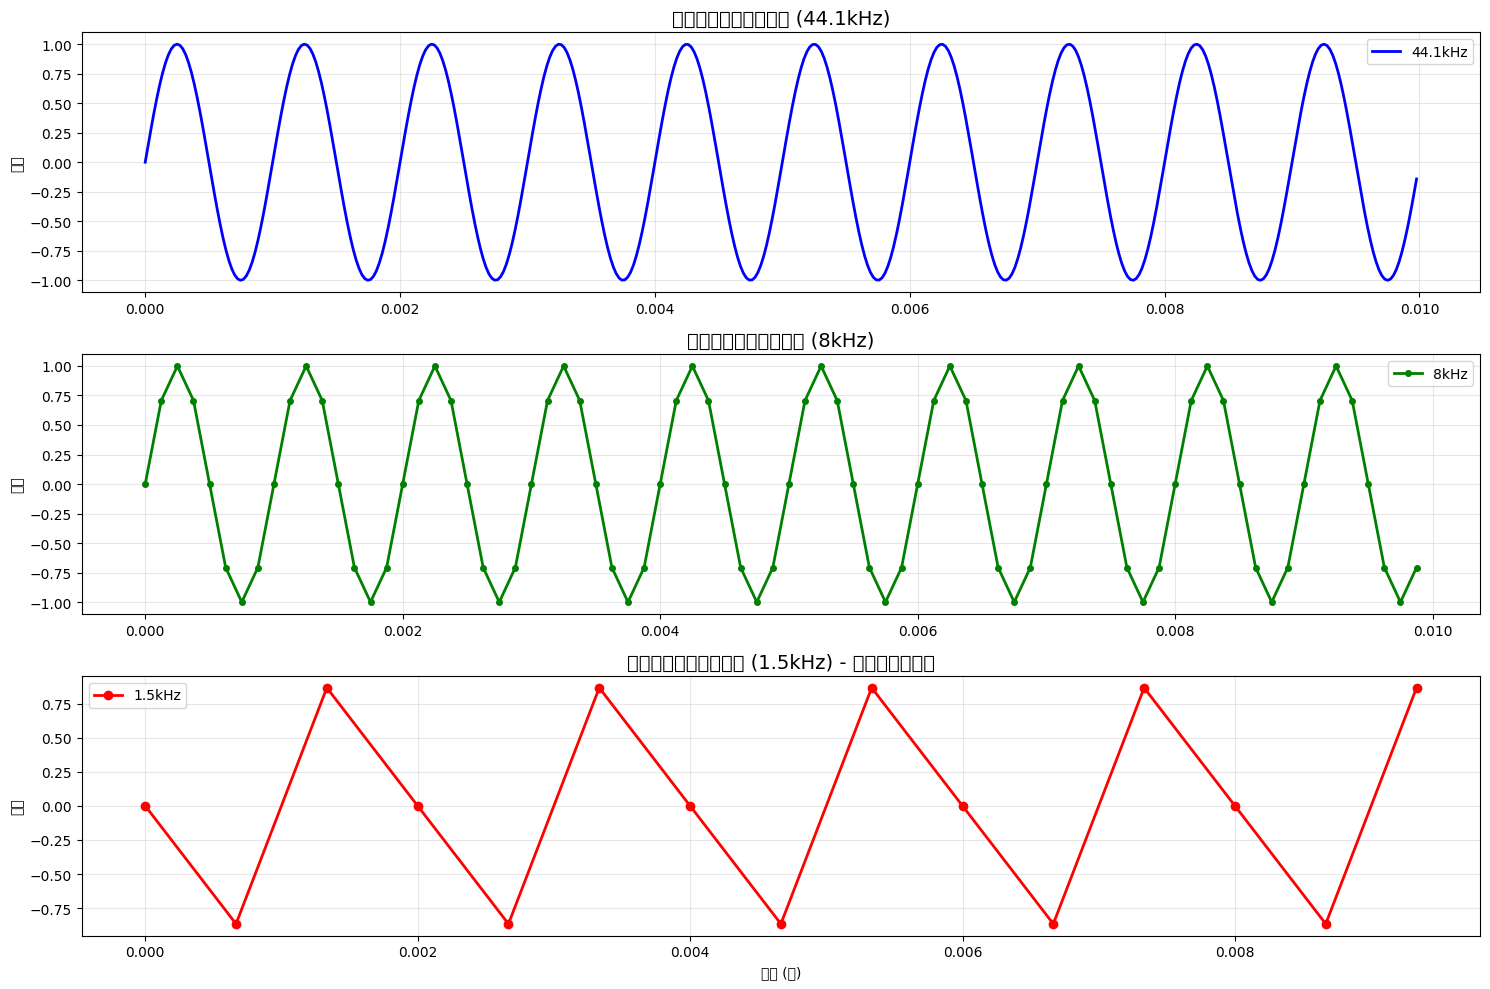

📊 点の密度でサンプリング周波数の違いがわかります


In [4]:
# 波形の可視化
plt.figure(figsize=(15, 10))

# 最初の0.01秒だけ表示（詳細を見るため）
zoom_duration = 0.01
zoom_samples_high = int(high_sr * zoom_duration)
zoom_samples_low = int(low_sr * zoom_duration)
zoom_samples_very_low = int(very_low_sr * zoom_duration)

plt.subplot(3, 1, 1)
plt.plot(t_high[:zoom_samples_high], signal_high[:zoom_samples_high], 'b-', linewidth=2, label='44.1kHz')
plt.title('高サンプリング周波数 (44.1kHz)', fontsize=14)
plt.ylabel('振幅')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t_low[:zoom_samples_low], signal_low[:zoom_samples_low], 'g-o', linewidth=2, markersize=4, label='8kHz')
plt.title('中サンプリング周波数 (8kHz)', fontsize=14)
plt.ylabel('振幅')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t_very_low[:zoom_samples_very_low], signal_very_low[:zoom_samples_very_low], 'r-o', linewidth=2, markersize=6, label='1.5kHz')
plt.title('低サンプリング周波数 (1.5kHz) - エイリアシング', fontsize=14)
plt.xlabel('時間 (秒)')
plt.ylabel('振幅')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

print("📊 点の密度でサンプリング周波数の違いがわかります")

## 🎵 音声ファイルの作成と分析

In [ ]:
# 複雑な音を作成（和音）
duration = 3.0
sample_rate = config.sample_rate

# Cメジャーコード（ド・ミ・ソ）
c_major_freqs = [261.63, 329.63, 392.00]  # C4, E4, G4

# 各音を生成（ヘルパー関数を使用）
chord_signal = create_chord(c_major_freqs, duration, sample_rate, sine_osc)

# エンベロープを適用
adsr = ADSREnvelope(attack=0.1, decay=0.2, sustain=0.7, release=0.5, config=config)
envelope_data = adsr.generate(duration)
chord_signal = apply_envelope(chord_signal, envelope_data)

# WAVファイルとして保存
sf.write('c_major_chord.wav', chord_signal, sample_rate)

print("🎵 Cメジャーコードを作成しました")
audio_player = play_sound(chord_signal, sample_rate, "Cメジャーコード")
display(audio_player)
print("📁 'c_major_chord.wav' として保存されました")

NameError: name 'config' is not defined

## 🎯 実習2: 音声ファイルの読み込みと基本分析

In [ ]:
# 音声ファイルの読み込み
audio_data, sr = librosa.load('c_major_chord.wav', sr=None)

print(f"📊 音声ファイル情報:")
print(f"   サンプリング周波数: {sr} Hz")
print(f"   データ長: {len(audio_data)} サンプル")
print(f"   再生時間: {len(audio_data) / sr:.2f} 秒")
print(f"   最大振幅: {np.max(np.abs(audio_data)):.3f}")
print(f"   RMS（実効値）: {np.sqrt(np.mean(audio_data**2)):.3f}")

# 波形の可視化
time_axis = np.linspace(0, len(audio_data) / sr, len(audio_data))

plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
plt.plot(time_axis, audio_data, 'b-', linewidth=1)
plt.title('Cメジャーコード - 時間波形', fontsize=16)
plt.xlabel('時間 (秒)')
plt.ylabel('振幅')
plt.grid(True, alpha=0.3)

# 最初の0.1秒の拡大表示
zoom_samples = int(0.1 * sr)
plt.subplot(2, 1, 2)
plt.plot(time_axis[:zoom_samples], audio_data[:zoom_samples], 'r-', linewidth=2)
plt.title('最初の0.1秒（拡大）', fontsize=16)
plt.xlabel('時間 (秒)')
plt.ylabel('振幅')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 🌈 フーリエ変換による周波数分析

### フーリエ変換とは？
**時間領域の信号を周波数領域に変換する数学的技法**

- 時間波形 → どの周波数成分がどれだけ含まれているか
- 和音の各音程を分離して見ることができる
- 楽器の音色分析に使用

## 🎯 実習3: FFT（高速フーリエ変換）による周波数分析

In [ ]:
# FFTの実行
# 中央部分（安定した部分）を抽出して分析
start_sample = int(0.5 * sr)  # 0.5秒後から
window_length = int(0.5 * sr)  # 0.5秒間
analysis_window = audio_data[start_sample:start_sample + window_length]

# 窓関数を適用（スペクトル漏れを防ぐ）
windowed_signal = analysis_window * np.hanning(len(analysis_window))

# FFT実行
fft_result = np.fft.fft(windowed_signal)
fft_magnitude = np.abs(fft_result)
fft_freq = np.fft.fftfreq(len(windowed_signal), 1/sr)

# 正の周波数のみ（対称性を利用）
positive_freq_idx = fft_freq >= 0
freq_positive = fft_freq[positive_freq_idx]
magnitude_positive = fft_magnitude[positive_freq_idx]

# デシベル変換
magnitude_db = 20 * np.log10(magnitude_positive + 1e-10)  # ゼロ除算防止

# 結果の可視化
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(freq_positive[:len(freq_positive)//10], magnitude_positive[:len(magnitude_positive)//10], 'g-', linewidth=2)
plt.title('周波数スペクトラム（線形スケール）', fontsize=16)
plt.xlabel('周波数 (Hz)')
plt.ylabel('振幅')
plt.grid(True, alpha=0.3)

# 期待される周波数にマーカーを追加
for freq, note in zip(c_major_freqs, ['C4', 'E4', 'G4']):
    plt.axvline(x=freq, color='red', linestyle='--', alpha=0.7, label=f'{note} ({freq:.1f} Hz)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(freq_positive[:len(freq_positive)//10], magnitude_db[:len(magnitude_db)//10], 'b-', linewidth=2)
plt.title('周波数スペクトラム（デシベルスケール）', fontsize=16)
plt.xlabel('周波数 (Hz)')
plt.ylabel('振幅 (dB)')
plt.grid(True, alpha=0.3)

# 期待される周波数にマーカーを追加
for freq, note in zip(c_major_freqs, ['C4', 'E4', 'G4']):
    plt.axvline(x=freq, color='red', linestyle='--', alpha=0.7, label=f'{note} ({freq:.1f} Hz)')
plt.legend()

plt.tight_layout()
plt.show()

print("🎵 和音の各音程が周波数スペクトラムに現れています！")
print("赤い破線が理論値、実際のピークと比較してみてください。")

In [ ]:
# ピーク検出
from scipy.signal import find_peaks

# 2000Hz以下の低周波域でピークを検出
low_freq_idx = freq_positive < 2000
low_freq = freq_positive[low_freq_idx]
low_magnitude = magnitude_positive[low_freq_idx]

# ピーク検出（閾値と最小距離を設定）
peaks, properties = find_peaks(low_magnitude, height=np.max(low_magnitude)*0.1, distance=20)

print("🔍 検出されたピーク周波数:")
for i, peak_idx in enumerate(peaks):
    detected_freq = low_freq[peak_idx]
    magnitude = low_magnitude[peak_idx]
    
    # 最も近い理論値を見つける
    closest_theoretical = min(c_major_freqs, key=lambda x: abs(x - detected_freq))
    error = abs(detected_freq - closest_theoretical)
    
    print(f"   ピーク {i+1}: {detected_freq:.1f} Hz (理論値: {closest_theoretical:.1f} Hz, 誤差: {error:.1f} Hz)")

print("\n💡 FFTで和音の構成音を正確に分析できました！")

## 🎯 実習4: スペクトログラム（時間-周波数分析）

In [ ]:
# 時間変化する音を作成
duration = 4.0
changing_signal = np.array([])

# スケール演奏（ド・レ・ミ・ファ・ソ・ラ・シ・ド）
scale_freqs = [261.63, 293.66, 329.63, 349.23, 392.00, 440.00, 493.88, 523.25]
note_duration = duration / len(scale_freqs)

adsr_short = ADSREnvelope(attack=0.05, decay=0.1, sustain=0.8, release=0.15, config=config)

for freq in scale_freqs:
    note = sine_osc.generate(freq, note_duration)
    envelope = adsr_short.generate(note_duration)
    note_with_env = apply_envelope(note, envelope)
    changing_signal = np.concatenate([changing_signal, note_with_env])

print("🎵 音階演奏")
audio_player = play_sound(changing_signal, sample_rate, "音階演奏（ドレミファソラシド）")
display(audio_player)

# スペクトログラムの計算
frequencies, times, Sxx = signal.spectrogram(
    changing_signal, 
    fs=sample_rate,
    window='hann',
    nperseg=1024,
    noverlap=512
)

# スペクトログラムの可視化
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
time_axis = np.linspace(0, len(changing_signal) / sample_rate, len(changing_signal))
plt.plot(time_axis, changing_signal, 'b-', linewidth=1)
plt.title('時間波形（音階演奏）', fontsize=16)
plt.xlabel('時間 (秒)')
plt.ylabel('振幅')
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.pcolormesh(times, frequencies[:200], 10*np.log10(Sxx[:200] + 1e-10), shading='gouraud', cmap='viridis')
plt.title('スペクトログラム（時間-周波数分析）', fontsize=16)
plt.xlabel('時間 (秒)')
plt.ylabel('周波数 (Hz)')
plt.colorbar(label='パワー (dB)')

# 理論的な音程を水平線で表示
for freq, note in zip(scale_freqs, ['C4', 'D4', 'E4', 'F4', 'G4', 'A4', 'B4', 'C5']):
    plt.axhline(y=freq, color='white', linestyle='--', alpha=0.7, linewidth=1)

plt.tight_layout()
plt.show()

print("🌈 スペクトログラムで音程の時間変化が見えます！")
print("明るい色ほど強い周波数成分を表します。")

## 🎯 実習5: リアルタイム音声処理の模擬

In [ ]:
# バッファサイズ（リアルタイム処理のブロックサイズ）
buffer_size = 1024
overlap = buffer_size // 2

# 処理対象の音声（前回作成した音階）
input_signal = changing_signal
output_signal = np.zeros_like(input_signal)

# シンプルなローパスフィルターの設計
lpf = LowPassFilter(cutoff_freq=1000, config=config)

print("🔄 リアルタイム処理シミュレーション開始")
print(f"バッファサイズ: {buffer_size} サンプル ({buffer_size/sample_rate*1000:.1f} ms)")

# バッファごとの処理
processing_times = []
num_buffers = (len(input_signal) - overlap) // (buffer_size - overlap)

for i in range(num_buffers):
    start_time = time.time()
    
    # バッファの開始・終了位置
    start_idx = i * (buffer_size - overlap)
    end_idx = start_idx + buffer_size
    
    if end_idx > len(input_signal):
        break
    
    # 入力バッファ
    input_buffer = input_signal[start_idx:end_idx]
    
    # 処理（ローパスフィルター適用）
    filtered_buffer = lpf.process(input_buffer)
    
    # 出力バッファに書き込み（オーバーラップ加算）
    output_end_idx = min(start_idx + buffer_size, len(output_signal))
    output_length = output_end_idx - start_idx
    output_signal[start_idx:output_end_idx] += filtered_buffer[:output_length]
    
    processing_time = time.time() - start_time
    processing_times.append(processing_time)
    
    if i % 10 == 0:  # 10バッファごとに進捗表示
        print(f"   バッファ {i+1}/{num_buffers} 処理完了 ({processing_time*1000:.2f} ms)")

print("\n✅ 処理完了")
print(f"平均処理時間: {np.mean(processing_times)*1000:.2f} ms/buffer")
print(f"最大処理時間: {np.max(processing_times)*1000:.2f} ms/buffer")
print(f"リアルタイム余裕度: {(buffer_size/sample_rate) / np.mean(processing_times):.1f}x")

print("\n🔊 オリジナル音声")
display(Audio(input_signal, rate=sample_rate))

print("\n🔊 フィルター適用後")
display(Audio(output_signal, rate=sample_rate))

print("\n💡 高音成分がカットされ、柔らかい音になりました！")

In [ ]:
# 処理前後の比較（スペクトラム）
# 中央部分を分析
analysis_start = len(input_signal) // 4
analysis_length = len(input_signal) // 2
analysis_end = analysis_start + analysis_length

input_segment = input_signal[analysis_start:analysis_end]
output_segment = output_signal[analysis_start:analysis_end]

# FFT
input_fft = np.fft.fft(input_segment * np.hanning(len(input_segment)))
output_fft = np.fft.fft(output_segment * np.hanning(len(output_segment)))

freqs = np.fft.fftfreq(len(input_segment), 1/sample_rate)
positive_idx = freqs >= 0
freqs_pos = freqs[positive_idx]
input_magnitude = np.abs(input_fft[positive_idx])
output_magnitude = np.abs(output_fft[positive_idx])

# 比較グラフ
plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
plt.plot(freqs_pos[:len(freqs_pos)//20], 20*np.log10(input_magnitude[:len(input_magnitude)//20] + 1e-10), 
         'b-', linewidth=2, label='処理前')
plt.plot(freqs_pos[:len(freqs_pos)//20], 20*np.log10(output_magnitude[:len(output_magnitude)//20] + 1e-10), 
         'r-', linewidth=2, label='処理後（LPF適用）')
plt.axvline(x=1000, color='green', linestyle='--', alpha=0.7, label='カットオフ周波数 (1kHz)')
plt.title('ローパスフィルター効果の周波数特性', fontsize=16)
plt.xlabel('周波数 (Hz)')
plt.ylabel('振幅 (dB)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
time_axis = np.linspace(0, len(input_signal) / sample_rate, len(input_signal))
plt.plot(time_axis, input_signal, 'b-', alpha=0.7, linewidth=1, label='処理前')
plt.plot(time_axis, output_signal, 'r-', alpha=0.7, linewidth=1, label='処理後')
plt.title('時間波形の比較', fontsize=16)
plt.xlabel('時間 (秒)')
plt.ylabel('振幅')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 1kHz以上の高周波成分が除去されています")

## 🏆 チャレンジ課題

In [ ]:
# チャレンジ1: あなただけの音を分析しよう
# 複数のオシレーターを組み合わせて複雑な音を作り、分析してください

# 異なる波形のオシレーター
square_osc = SquareWave(config)
saw_osc = SawtoothWave(config)

# あなたのオリジナル音（パラメータを変更してください）
duration = 2.0
fundamental_freq = 220  # A3

# 複数の波形を組み合わせ
sine_component = sine_osc.generate(fundamental_freq, duration) * 0.5
square_component = square_osc.generate(fundamental_freq, duration) * 0.3
saw_component = saw_osc.generate(fundamental_freq * 1.5, duration) * 0.2  # 5度上

# 合成
complex_signal = sine_component + square_component + saw_component

# エンベロープ適用
envelope = ADSREnvelope(attack=0.1, decay=0.3, sustain=0.6, release=0.8, config=config)
env_data = envelope.generate(duration)
complex_signal = apply_envelope(complex_signal, env_data)

print("🎵 あなたのオリジナル音色")
audio_player = play_sound(complex_signal, sample_rate, "オリジナル音色")
display(audio_player)

# 分析
complex_fft = np.fft.fft(complex_signal * np.hanning(len(complex_signal)))
complex_freqs = np.fft.fftfreq(len(complex_signal), 1/sample_rate)
positive_idx = complex_freqs >= 0
complex_freqs_pos = complex_freqs[positive_idx]
complex_magnitude = np.abs(complex_fft[positive_idx])

plt.figure(figsize=(12, 6))
plt.plot(complex_freqs_pos[:len(complex_freqs_pos)//10], 
         20*np.log10(complex_magnitude[:len(complex_magnitude)//10] + 1e-10), 
         'purple', linewidth=2)
plt.axvline(x=fundamental_freq, color='red', linestyle='--', alpha=0.7, label=f'基音 ({fundamental_freq} Hz)')
plt.axvline(x=fundamental_freq*1.5, color='orange', linestyle='--', alpha=0.7, label=f'5度 ({fundamental_freq*1.5} Hz)')
plt.title('あなたのオリジナル音色 - 周波数分析', fontsize=16)
plt.xlabel('周波数 (Hz)')
plt.ylabel('振幅 (dB)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("🔍 倍音成分や組み合わせた波形の特徴が見えますか？")

In [ ]:
# チャレンジ2: エフェクト付きリアルタイム処理
# 複数のエフェクトを組み合わせてリアルタイム処理してみましょう

# 入力信号（あなたのオリジナル音）
input_signal = complex_signal
output_signal = np.zeros_like(input_signal)

# エフェクトチェーン
lpf = LowPassFilter(cutoff_freq=2000, config=config)
# 必要に応じて他のエフェクトも追加できます

# バッファ処理
buffer_size = 512
num_buffers = len(input_signal) // buffer_size

print("🎛️ エフェクトチェーン処理開始")

for i in range(num_buffers):
    start_idx = i * buffer_size
    end_idx = start_idx + buffer_size
    
    if end_idx > len(input_signal):
        break
    
    # 入力バッファ
    input_buffer = input_signal[start_idx:end_idx]
    
    # エフェクト適用
    processed_buffer = lpf.process(input_buffer)
    # 必要に応じてさらなるエフェクトを追加
    
    # 出力
    output_signal[start_idx:end_idx] = processed_buffer

print("✅ エフェクト処理完了")

print("\n🔊 エフェクト前")
audio_before = play_sound(input_signal, sample_rate, "エフェクト前")
display(audio_before)

print("\n🔊 エフェクト後")
audio_after = play_sound(output_signal, sample_rate, "エフェクト後（ローパスフィルター適用）")
display(audio_after)

print("\n🎉 あなただけのエフェクト音の完成です！")

## 📚 今日のまとめ

### 学んだこと
1. **サンプリング理論**: ナイキスト定理とエイリアシング
2. **音声ファイル処理**: 読み込み、基本情報の取得
3. **フーリエ変換**: 時間領域→周波数領域の変換
4. **周波数分析**: FFTによるスペクトラム解析
5. **スペクトログラム**: 時間-周波数の2次元分析
6. **リアルタイム処理**: バッファベースの処理技法

### 使ったライブラリ・技術
- `numpy.fft`: 高速フーリエ変換
- `scipy.signal`: スペクトログラム、ピーク検出
- `librosa`: 音声ファイル読み込み
- `soundfile`: 音声ファイル書き込み
- 窓関数、オーバーラップ処理

### 実用的な応用
- **音楽分析**: 楽器認識、音程検出
- **音響効果**: リアルタイムエフェクト
- **音声処理**: ノイズ除去、音質改善
- **研究開発**: 音響特性の解析

### デジタル音声の基本
- サンプリング周波数とビット深度の重要性
- 周波数領域での音の理解
- リアルタイム制約と処理効率

### 次回予告
いよいよ最終回！「**音楽制作プロジェクト・発表会**」
これまでの学習を総動員して、あなただけのオリジナル音楽作品を作ります。
楽器の音色設計から楽曲構成まで、クリエイティブな音楽制作に挑戦しましょう！

---
**お疲れさまでした！** 🎉

音の世界の奥深さを感じていただけたでしょうか？
次回は、これまで学んだ全てを使って素晴らしい作品を作りましょう！